# Code playground
This notebook is a small sandbox where half baked ideas can live. Code snippets that were developed but might be useful saterr can go here.

In [165]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchtext
import tqdm
from torchnlp.metrics import get_moses_multi_bleu
from torchtext.data import Field, BucketIterator
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

import tensorflow as tf
import tensorflow_datasets as tfds
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP
from io import BytesIO

import matplotlib.pyplot as plt

import linecache
import sys
import os
import re
import random
import time
# import streamtologger
# streamtologger.redirect(target="./logs-playground.log")

In [2]:
from datetime import datetime
def super_print(filename):
    '''filename is the file where output will be written'''
    def wrap(func):
        '''func is the function you are "overriding", i.e. wrapping'''
        def wrapped_func(*args,**kwargs):
            '''*args and **kwargs are the arguments supplied 
            to the overridden function'''
            #use with statement to open, write to, and close the file safely
            with open(filename,'a') as outputfile:
                now = datetime.now()
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                outputfile.write("[{}] ".format(dt_string))
                outputfile.write(" ".join(str(x) for x in args))
                outputfile.write("\n")
            #now original function executed with its arguments as normal
            return func(*args,**kwargs)
        return wrapped_func
    return wrap

print = super_print('logs-playground.txt')(print)

In [20]:
torch.tensor([1,4,3,6,2]).argsort()

tensor([0, 4, 2, 1, 3])

In [21]:
rand_transformer_model = nn.Transformer().to("cuda") # uses default hyperparameters
src = torch.rand((10, 32, 512)).to("cuda") # [src_seq_length, batch_size, embedding_size]
tgt = torch.rand((20, 32, 512)).to("cuda") # [tgt_seq_length, batch_size, embedding_size]
rand_transformer_model(src, tgt).shape # [tgt_seq_length, batch_size, embedding_size]

torch.Size([20, 32, 512])

In [22]:
rand_transformer_model.decoder.layers[-1]

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)

In [31]:
q = torch.rand((20, 32, 512))
k = torch.rand((10, 32, 512))
v = torch.rand((10, 32, 512))
att = nn.MultiheadAttention(512, 2)
attn_output = att(q, k, v)
# attn_output

## Self-made beam search code
This code runs on paralelised batches and beams, it's fast, but doesn't have the appropriate stopping conditions.

In [ ]:
def beam_search_decode_batch_ids(encoder_input, beam_size=3, max_seq_length=50):
    batch_len = encoder_input.shape[1]
    sos_id = TGT_TEXT.vocab.stoi["<sos>"]
    decoder_input = torch.zeros((1, beam_size * batch_len), dtype=torch.long, device=device).fill_(sos_id)
    log_probs = torch.zeros((beam_size * batch_len,1))
    print("log_probs:", log_probs)
    vocab_size = len(TGT_TEXT.vocab.itos)
    
    encoder_input = encoder_input.view(-1,1).repeat(1,beam_size).view(-1,beam_size * batch_len) # this tiles the input to the beam size * batch size
    print("tiled input:", encoder_input)
    
    for i in range(max_seq_length):
        output = model(encoder_input, decoder_input)
        print(output.shape)
        last_pred = output[-1].softmax(1)
        print("last_pred shape:", last_pred.shape)
        log_predictions = last_pred.log()
        seq_log_probs = log_predictions + log_probs.repeat(1,vocab_size)
        print("seq_log_probs:", seq_log_probs)
        
        seq_log_probs_positions = seq_log_probs.view(batch_len,-1).argsort(1)[:,-beam_size:]
        print("seq_log_probs_positions:", seq_log_probs_positions)
        next_ids = seq_log_probs_positions.reshape(1, batch_len*beam_size) % vocab_size
        print("next_ids:", next_ids)
        log_probs = seq_log_probs.view(batch_len,-1).gather(1,seq_log_probs_positions).view(beam_size * batch_len,1)
        print("log_probs:",log_probs)
        
        for batch_idx in range(seq_log_probs_positions.shape[0]):
            for seq_choice_idx in range(seq_log_probs_positions.shape[1]):
                seq_choice = seq_log_probs_positions[batch_idx,seq_choice_idx] // vocab_size
                decoder_input[:,batch_idx*batch_len + seq_choice_idx] = decoder_input[:,batch_idx*batch_len + seq_choice]
        
        decoder_input = torch.cat((decoder_input, next_ids))
    return decoder_input
        
#         last_pred = output[-1].argsort(dim=1)[:,:beam_size]

sent1 = ["<sos>"] + SRC_TEXT.preprocess("create array") + ["<eos>"] + ["<pad>"]
sent2 = ["<sos>"] + SRC_TEXT.preprocess("if exists then") + ["<eos>"]
src_ids = SRC_TEXT.numericalize([sent1, sent2], device=device)
print("input ids:", src_ids)
beam_search_decode_batch_ids(src_ids, max_seq_length=5)

## Non batch single node beam search
This is the original beam search from online simply adapted to suit the transformerr architecture.

In [ ]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length
        
    def __lt__(self, other):
        return True

    def eval(self, alpha=1.0):
        reward = 0
        beta = 4.0
        # Add here a function for shaping a reward

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward

In [ ]:
def beam_decode(model, encoder_states):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    beam_width = 10
    topk = 3  # how many sentence do you want to generate
    decoded_batch = []
    
    SOS_token = TGT_TEXT.vocab.stoi["<sos>"]
    EOS_token = TGT_TEXT.vocab.stoi["<eos>"]
    MAX_LENGTH = 7
    
    batch_size = encoder_states.shape[1]

    # decoding goes sentence by sentence
    for idx in range(batch_size):
        encoder_input = encoder_states[:, idx].view(-1,1)
        
        # Start with the start of the sentence token
        decoder_input = torch.LongTensor([[SOS_token]]).to(device)

        # Number of sentence to generate
        endnodes = []
        number_required = min((topk + 1), topk - len(endnodes))

        # starting node -  hidden vector, previous node, word id, logp, length
        node = BeamSearchNode(decoder_input, None, SOS_token, 0, 1)
        nodes = PriorityQueue()

        # start the queue
        nodes.put((-node.eval(), node))
        qsize = 1

        # start beam search
        while True:
            # give up when decoding takes too long
            if qsize > 400: break

            # fetch the best node
            score, n = nodes.get()
#             decoder_input = n.wordid
            decoder_input = n.h

            if n.wordid == EOS_token and n.prevNode != None:
                endnodes.append((score, n))
                # if we reached maximum # of sentences required
                if len(endnodes) >= number_required:
                    break
                else:
                    continue

            # decode for one step using decoder
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)
#             print(encoder_input)
#             print(decoder_input)
            decoder_output = model(encoder_input, decoder_input)
            last_token_logits = decoder_output[-1]
            last_token_logs = last_token_logits.log_softmax(1)
            # PUT HERE REAL BEAM SEARCH OF TOP
            log_prob, indexes = torch.topk(last_token_logs, beam_width)
            nextnodes = []

            for new_k in range(beam_width):
                decoded_t = indexes[0][new_k]
                log_p = log_prob[0][new_k].item()
                decoder_input = torch.cat((decoder_input,decoded_t.view(1,-1)))
                node = BeamSearchNode(decoder_input, n, decoded_t.cpu().item(), n.logp + log_p, n.leng + 1)
                score = -node.eval()
                nextnodes.append((score, node))

            # put them into queue
            for i in range(len(nextnodes)):
                score, nn = nextnodes[i]
                nodes.put((score, nn))
                # increase qsize
            qsize += len(nextnodes) - 1

        # choose nbest paths, back trace them
        if len(endnodes) == 0:
            endnodes = [nodes.get() for _ in range(topk)]

        utterances = []
        for score, n in sorted(endnodes, key=operator.itemgetter(0)):
            utterance = []
            utterance.append(n.wordid)
            # back trace
            while n.prevNode != None:
                n = n.prevNode
                utterance.append(n.wordid)

            utterance = utterance[::-1]
            utterances.append(utterance)

        decoded_batch.append(utterances)

    return decoded_batch

sent1 = ["<sos>"] + SRC_TEXT.preprocess("call the options.get method with string 'CULL_FREQUENCY' and integer 3 as arguments, use the string 'cull_frequency' and previous result as the arguments for the call to the params.get method, substitute the result for cull_frequency.") + ["<eos>"] + ["<pad>"]
# sent2 = ["<sos>"] + SRC_TEXT.preprocess("if not,") + ["<eos>"]
src_ids = SRC_TEXT.numericalize([sent1], device=device)
# print("input ids:", src_ids)
outs = beam_decode(model, encoder_states=src_ids)

for b in outs:
    for sent in b:
        print([TGT_TEXT.vocab.itos[id] for id in sent])

## Adaptation of node based beam search to parallelise batches
This version comes from an already working version for a single batch. But there is a problem since when decodng different batches and passing them to the transformer, they all need to be the same length which doesn't work since there could be a node made in the past with a better probability score.
It doesn't look too obvious from what I see to speed it up while rretaining the theoretical benefits of being able to explore the full tree of options.

### The solution
You just need to add padding to the decoded sequences that are shorter and keep track of the position that you need to take the output token from. easy.

In [3]:
def beam_decode(model, encoder_states):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    beam_width = 10
    topk = 3  # how many sentence do you want to generate
    decoded_batch = []
    
    batch_size = encoder_states.shape[1]
    
    SOS_token = TGT_TEXT.vocab.stoi["<sos>"]
    EOS_token = TGT_TEXT.vocab.stoi["<eos>"]
    MAX_LENGTH = 7

    # decoding goes all batches at the same time
    encoder_input = encoder_states

    # Start with the start of the sentence token
    decoder_input = torch.LongTensor([[SOS_token]]).to(device)

    # Number of sentence to generate
    batch_endnodes = [[] for i in range(batch_size)]
    number_required = topk

    # starting node -  hidden vector, previous node, word id, logp, length
    batch_node = [BeamSearchNode(decoder_input, None, SOS_token, 0, 1) for i in range(batch_size)]
    batch_nodes = [PriorityQueue() for i in range(batch_size)]

    # start the queue
    for nodes, node in zip(batch_nodes, batch_node):
        nodes.put((-node.eval(), node))
        
    batch_qsize = [1 for i in range(batch_size)]

    # start beam search
    while True:
        # give up when decoding takes too long for the first batch, placeholder for now
        print(batch_qsize)
        if batch_qsize[0] > 200: break

        # fetch the best node
        best_nodes = [nodes.get() for nodes in batch_nodes]
#         score, n = nodes.get()
#             decoder_input = n.wordid
#         decoder_input = n.h
        
        finished_nodes = [True if n.wordid == EOS_token and n.prevNode != None else False for (score, n) in best_nodes]
        print(finished_nodes)
        
        working_nodes = []
        working_node_id = 0
        working_nodes_idx = []
        for endnodes, (score, n) in zip(batch_endnodes, best_nodes):
            if n.wordid == EOS_token and n.prevNode != None and len(endnodes) < number_required:
                endnodes.append((score, n))
            else:
                working_nodes.append((score, n))
                working_nodes_idx.append(working_node_id)
            working_node_id += 1
        
        if all([len(endnodes) >= number_required for endnodes in batch_endnodes]):
            break
        
        num_working_nodes = len(working_nodes)
        print(working_nodes)
        
        step_encoder_input = encoder_input[:,:num_working_nodes].view(-1,num_working_nodes)
        print("[n.h for (score, n) in working_nodes] shape:", [n.h.shape for (score, n) in working_nodes])
        step_decoder_input = torch.cat([n.h for (score, n) in working_nodes],dim=1)
#         print("step_encoder_input shape:", step_encoder_input.shape)
        step_decoder_output = model(step_encoder_input, step_decoder_input)
        step_token_logits = step_decoder_output[-1]
        
        print(step_token_logits)

        # PUT HERE REAL BEAM SEARCH OF TOP
        log_prob, indexes = torch.topk(step_token_logits, beam_width)
        print(log_prob.shape)
        
    
        nextnodes = []
        
        for batch_id in working_nodes_idx:
            for new_k in range(beam_width):
                decoded_t = indexes[batch_id][new_k]
                log_p = log_prob[batch_id][new_k].item()
#                 print("decoder_input shape", step_decoder_input.shape)
#                 print("step_decoder_input shape:", step_decoder_input[:,batch_id].view(-1,1).shape)
#                 print("decoded_t shape:", decoded_t.view(1,-1).shape)
                decoder_input = torch.cat((step_decoder_input[:,batch_id].view(-1,1),decoded_t.view(1,-1)), dim=0)
#                 print("decoder_input shape:", decoder_input.shape)
                node = BeamSearchNode(decoder_input, working_nodes[batch_id], decoded_t.cpu().item(), n.logp + log_p, n.leng + 1)
                score = -node.eval()
                batch_nodes[batch_id].put((score, node))
                batch_qsize[batch_id] += 1
        
        # put them into queue
#         for i in range(len(nextnodes)):
#             score, nn = nextnodes[i]
#             nodes.put((score, nn))
#             # increase qsize
#         qsize += len(nextnodes) - 1

    # choose nbest paths, back trace them
    if len(endnodes) == 0:
        endnodes = [nodes.get() for _ in range(topk)]

    utterances = []
    for score, n in sorted(endnodes, key=operator.itemgetter(0)):
        utterance = []
        utterance.append(n.wordid)
        # back trace
        while n.prevNode != None:
            n = n.prevNode
            utterance.append(n.wordid)

        utterance = utterance[::-1]
        utterances.append(utterance)

    decoded_batch.append(utterances)

    return decoded_batch

sent1 = ["<sos>"] + SRC_TEXT.preprocess('try,') + ["<eos>"] + ["<pad>"]
sent2 = ["<sos>"] + SRC_TEXT.preprocess("if not,") + ["<eos>"]
src_ids = SRC_TEXT.numericalize([sent1, sent2], device=device)
# print("input ids:", src_ids)
[len(x) for x in beam_decode(model, encoder_states=src_ids)[0]]

NameError: name 'SRC_TEXT' is not defined

## Debug dataset

In [ ]:
# debug_data = [
#     ("my favourite foods are banana and toast","would you like banana and toast ?"),
#     ("my favourite foods are eggs and bacon and beans","would you like eggs and bacon and beans ?"),
#     ("my favourite food is chocolate","would you like chocolate ?"),
#     ("my favourite food is avocado","would you like avocado ?")
# ]

# other_data = [
#     ("what age is she ?", "she is 8 years old"),
#     ("what age is he ?", "he is 4 years old"),
#     ("how old are you ?", "i am 22 years old"),
#     ("how old am i ?", "you are 28 years old")
# ]

# SRC_TEXT = Field(sequential=True, tokenize=string_split, init_token='<sos>',eos_token='<eos>')
# TGT_TEXT = Field(sequential=True, tokenize=string_split, init_token='<sos>',eos_token='<eos>')

# train_dataset = val_dataset = samples_to_dataset(other_data, SRC_TEXT, TGT_TEXT)

# # train_dataset, val_dataset = dataset.split([0.7,0.3])

## Adding Noise to the decoding process during training

In [85]:
noise_e = 0.4
noise_mask = (torch.rand(10,10) > noise_e).float()

mask = (torch.triu(torch.ones(10,10))).transpose(0, 1)
mask = torch.mul(mask, noise_mask)
v = (torch.sum(mask, dim=-1) == 0).float()

fix_mask = torch.zeros(10,10)
fix_mask[:,0] = 1.0
v = v.repeat(10, 1).transpose(0,1)
fix_mask = torch.mul(fix_mask,v)

print(fix_mask)
mask += fix_mask


mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
mask

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf],
        [-inf, 0., 0., -inf, -inf, 0., -inf, -inf, -inf, -inf],
        [0., -inf, 0., 0., -inf, -inf, 0., -inf, -inf, -inf],
        [-inf, 0., 0., -inf, 0., 0., 0., 0., -inf, -inf],
        [-inf, 0., 0., 0., 0., -inf, 0., -inf, 0., -inf],
        [0., -inf, 0., 0., -inf, 0., -inf, 0., -inf, -inf]])

## Pytorch target masking transformer bug
There is a bug in the implementation of the transformer attention mask during decoding. It being produced the other way round, paying attention to parts of the sentence that appear at the end. It is a simple to fix at removing ==1

In [2]:
model = nn.Transformer()
model.generate_square_subsequent_mask(4)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [82]:
sz = 4
mask = (torch.triu(torch.ones(sz, sz))==1).transpose(0, 1).float()
print(mask)
mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])


tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [74]:
a = (torch.ones(10)==1)
a.masked_fill(a == 1, float('-inf'))

tensor([True, True, True, True, True, True, True, True, True, True])

In [146]:
from queue import PriorityQueue
a = PriorityQueue()
a.put(torch.tensor(1))
a.put(torch.tensor(-2))
a.get()

tensor(-2)

In [128]:
a = torch.tensor([[1],[2],[3]])
b = torch.tensor([[3],[4]])
rough_input = [a,b]
m = max([t.shape[0] for t in rough_input])
print(m)
z = torch.zeros((m,2)).fill_(7)
for i in range(2):
    length = rough_input[i].shape[0]
    z[:length,i] = rough_input[i].view(-1)
print(z)

3
tensor([[1., 3.],
        [2., 4.],
        [3., 7.]])


In [140]:
outputs = torch.tensor([[[1],[5]],[[2],[6]],[[3],[7]],[[4],[8]]]).transpose(0,1)
p_mask = [2,3]

for l in outputs[]:
    print(l)

tensor([[1],
        [2],
        [3],
        [4]])
tensor([[5],
        [6],
        [7],
        [8]])


In [10]:
a = torch.tensor([1.,2,3,4, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).softmax(0)
a

tensor([0.0259, 0.0705, 0.1917, 0.5210, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095])

In [13]:
atts = torch.rand(2,4,3).transpose(0,1) # [output_seq_length, batch_size, input_seq_length]
print("atts:", atts)
print("atts.shape:", atts.shape)

# atts = atts * torch.tensor([[[0.1],[1]],[[10],[100]],[[1000],[10000]],[[100000],[1000000]]])
print("atts:", atts)

# src = torch.randint(0, 10, (3,2))
src = torch.tensor([[1,2],
                    [3,4],
                    [5,6]])
print("src:", src)
src = src.transpose(0,1)
print("src.T:", src)
src = src.unsqueeze(0)
print("src.unsqueeze:", src)
src = torch.repeat_interleave(src, 4, dim=0)
print("src.inter:", src)
print("src.inter.shape:", src.shape)

out_dist = torch.zeros(4, 2, 10).scatter_add_(2,src,atts)
print(out_dist)

atts: tensor([[[0.0248, 0.1017, 0.7406],
         [0.8730, 0.7230, 0.6886]],

        [[0.0148, 0.6740, 0.0523],
         [0.4018, 0.8585, 0.9774]],

        [[0.9876, 0.9629, 0.4758],
         [0.0139, 0.4103, 0.1767]],

        [[0.9024, 0.3109, 0.5361],
         [0.5023, 0.6643, 0.6590]]])
atts.shape: torch.Size([4, 2, 3])
atts: tensor([[[0.0248, 0.1017, 0.7406],
         [0.8730, 0.7230, 0.6886]],

        [[0.0148, 0.6740, 0.0523],
         [0.4018, 0.8585, 0.9774]],

        [[0.9876, 0.9629, 0.4758],
         [0.0139, 0.4103, 0.1767]],

        [[0.9024, 0.3109, 0.5361],
         [0.5023, 0.6643, 0.6590]]])
src: tensor([[1, 2],
        [3, 4],
        [5, 6]])
src.T: tensor([[1, 3, 5],
        [2, 4, 6]])
src.unsqueeze: tensor([[[1, 3, 5],
         [2, 4, 6]]])
src.inter: tensor([[[1, 3, 5],
         [2, 4, 6]],

        [[1, 3, 5],
         [2, 4, 6]],

        [[1, 3, 5],
         [2, 4, 6]],

        [[1, 3, 5],
         [2, 4, 6]]])
src.inter.shape: torch.Size([4, 2, 3])
ten

# Python AST doodles

In [4]:
import ast
import astor

import execnet
import inspect

In [5]:
def call_python_version(Version, Module, Function, ArgumentList):
    gw      = execnet.makegateway("popen//python=python%s" % Version)
    channel = gw.remote_exec("""
        from %s import %s as the_function
        channel.send(the_function(*channel.receive()))
    """ % (Module, Function))
    channel.send(ArgumentList)
    return channel.receive()

In [6]:
def foo(*bar):
    print(bar)

In [7]:
func_source = inspect.getsource(foo)
print(func_source)

def foo(*bar):
    print(bar)



In [8]:
foo("this", "is")

('this', 'is')


In [9]:
def run_as_python2(code_string):
    gw = execnet.makegateway("popen//python=python2")
    channel = gw.remote_exec(f"""
        channel.send("the_function(*channel.receive())")""")

In [10]:
result = call_python_version("3", "python2_code", "my_function",  
                             ["Mr", "Bear"]) 
print(result) 
result = call_python_version("2", "python2_code", "string_py2_ast",  
                             ["print 'foo' "]) 
print(result)

Hello Mr Bear!


RemoteError: Traceback (most recent call last):
  File "<string>", line 1084, in executetask
  File "<string>", line 1, in do_exec
  File "<remote exec>", line 3, in <module>
  File "<string>", line 729, in send
  File "<string>", line 1371, in dumps_internal
  File "<string>", line 1389, in save
  File "<string>", line 1405, in _save
DumpError: can't serialize <class '_ast.Module'>


In [78]:
eval("Store")

_ast.Store

In [65]:
from collections.abc import Iterable

def is_primitive(obj):
    return any([isinstance(obj, str),isinstance(obj, int),isinstance(obj, float)])

def ast_to_production_rules(tree):
    
    fields = tree._fields
    name = type(tree).__name__
    print(name, end =" ")
    
    for field in fields:
        field_obj = getattr(tree, field)
        
        if field_obj==None:
            continue
            
        elif is_primitive(field_obj):
            print(field, end=" ")
            print(field_obj, end=" ")
            
        elif isinstance(field_obj, Iterable):
            print(field, end=" ")
            for elem in field_obj:
                ast_to_production_rules(elem)
            print("<end_list>", end=" ")
        else:
            print(field, end=" ")
            ast_to_production_rules(field_obj)
        
        


In [143]:
ast_to_production_rules(tree)

Module body Assign targets Name id a ctx Store <end_list> value Num n 0.4 <end_list> 

In [125]:
a='this \' is'
a

"this ' is"

In [541]:
code_string = "if p . find ( ':_(' ) >= 0 : pass"
tree = ast.parse(code_string)
# tree = ast.parse("a='foo'")
print(ast.dump(tree))
print()
print(astor.to_source(tree))

Module(body=[If(test=Compare(left=Call(func=Attribute(value=Name(id='p', ctx=Load()), attr='find', ctx=Load()), args=[Str(s=':_(')], keywords=[]), ops=[GtE()], comparators=[Num(n=0)]), body=[Pass()], orelse=[])])

if p.find(':_(') >= 0:
    pass



In [542]:
def to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

In [545]:
import importlib

def new_dump_to_ast(dump_string):
    first_paren = dump_string.index("(")
    node_string = dump_string[:first_paren]
#     print(1, "creating node type:", node_string)
    module = importlib.import_module("ast")
    class_ = getattr(module, node_string)
    node = class_()
    inner_paren = dump_string[first_paren+1:-1]
    
    # handle variable length attributes
    while len(inner_paren) > 0:
        print(2, "Attr string so far:", inner_paren)
        equal_idx = inner_paren.index("=")
        attr_string = inner_paren[:equal_idx]
        print(3, "attribute name:", attr_string)
        
        # 5 cases: None, num, string, list, node
        # first check if None
#         print(4, "checking None:", inner_paren[equal_idx+1:equal_idx+5])
#         print(5, "checking number:", inner_paren[equal_idx+1], inner_paren[equal_idx+1].isnumeric())
        print(6, "checking Quote or DQuote:", inner_paren[equal_idx+1] == "'" or inner_paren[equal_idx+1] == '"')
        
        if inner_paren[equal_idx+1:equal_idx+5] == "None":
            setattr(node, attr_string, None)
            inner_paren = inner_paren[equal_idx + 7:]
        
        elif inner_paren[equal_idx+1:equal_idx+5] == "True":
            setattr(node, attr_string, True)
            inner_paren = inner_paren[equal_idx + 7:]
            
        elif inner_paren[equal_idx+1:equal_idx+6] == "False":
            setattr(node, attr_string, False)
            inner_paren = inner_paren[equal_idx + 8:]
            
        # check if first character is a number
        elif inner_paren[equal_idx+1].isnumeric():
            number_finder = re.compile("([0-9]+(.?[0-9]*))( *([a-zA-Z]+))*")
            groups = number_finder.match(inner_paren[equal_idx+1:]).groups()
#             print(6, "Number groups identified:", groups)
            num = to_num(groups[0])
#             print(7, "Number:", num)
            setattr(node, attr_string, num)
            inner_paren = inner_paren[equal_idx + len(groups[0])+2:]
        
        # check if first Character is quote or double quote to see if it's a string
        elif inner_paren[equal_idx+1] == "'" or inner_paren[equal_idx+1] == '"':
            string_matcher = re.compile("['\"](.*?)['\"]")
            string = temp.findall(inner_paren[equal_idx:])[0]
            setattr(node, attr_string, string)
            inner_paren = inner_paren[equal_idx + len(string)+5:]
        
        elif inner_paren[equal_idx+1] == "'" or inner_paren[equal_idx+1] == '"':
            string_matcher = re.compile("['\"](.*?)['\"]")
            string = temp.findall(inner_paren[equal_idx:])[0]
            setattr(node, attr_string, string)
            inner_paren = inner_paren[equal_idx + len(string)+5:]
        
        # deal with list
        elif inner_paren[equal_idx+1] == "[":
            list_last_square = get_square_index(inner_paren, equal_idx+1)
            list_string = inner_paren[equal_idx+2:list_last_square]
            
            elem_list = []
            while len(list_string) > 0:
#                 print(8, "List string so far:", list_string)
                value_first_paren = list_string.index("(")
                value_last_paren = get_paren_index(list_string, value_first_paren)
                list_value_ast = new_dump_to_ast(list_string[:value_last_paren+1])
                elem_list.append(list_value_ast)
                list_string = list_string[value_last_paren+3:]
            setattr(node, attr_string, elem_list)
            inner_paren = inner_paren[list_last_square+3:]
        
        # deal with node
        else:
            value_first_paren = inner_paren.index("(")        
            value_last_paren = get_paren_index(inner_paren, value_first_paren)
#             print(9,"handling Node for: ",inner_paren[equal_idx+1:value_last_paren+1])
            value_ast = new_dump_to_ast(inner_paren[equal_idx+1:value_last_paren+1])
#             print(10, f"obtained AST for{attr_string}:", value_ast)
            setattr(node, attr_string, value_ast)
            inner_paren = inner_paren[value_last_paren+3:]
    
    
    return node

print(ast.dump(tree))
print()
t = tree.body[0]
print("Reduced tree:", ast.dump(t))
new_ast = new_dump_to_ast(ast.dump(t))

print()
print(ast.dump(new_ast))

print()
print(f"OG String    : {code_string}")
print(f"Code from AST: {astor.to_source(t)}")
print(f"Rebuilt AST  : {astor.to_source(new_ast)}")

Module(body=[If(test=Compare(left=Call(func=Attribute(value=Name(id='p', ctx=Load()), attr='find', ctx=Load()), args=[Str(s=':_(')], keywords=[]), ops=[GtE()], comparators=[Num(n=0)]), body=[Pass()], orelse=[])])

Reduced tree: If(test=Compare(left=Call(func=Attribute(value=Name(id='p', ctx=Load()), attr='find', ctx=Load()), args=[Str(s=':_(')], keywords=[]), ops=[GtE()], comparators=[Num(n=0)]), body=[Pass()], orelse=[])
2 Attr string so far: test=Compare(left=Call(func=Attribute(value=Name(id='p', ctx=Load()), attr='find', ctx=Load()), args=[Str(s=':_(')], keywords=[]), ops=[GtE()], comparators=[Num(n=0)]), body=[Pass()], orelse=[]
3 attribute name: test
6 checking Quote or DQuote: False


ValueError: substring not found

In [332]:
import importlib
module = importlib.import_module("ast")
class_ = getattr(module, "Module")
instance = class_()
type(instance)

_ast.Module

In [538]:
with open("datasets/all.code", "r") as f:
    count = 0
    all_lines = 0
    for line in f.readlines():
        all_lines+=1
        try:
            can_code = canonicalize_code(line[:-1])
            code_ast = ast.parse(can_code)
            new_ast = new_dump_to_ast(ast.dump(code_ast))
            can_code_ast = astor.to_source(new_ast)

            de_can_code_ast = de_canonicalize_code(can_code_ast, code)
            de_can_code_ast = re.sub(r'\n', '', de_can_code_ast)
            count += 1
        except:
            print(line[:-1])
            pass
print(f"{count}/{all_lines} = {count*100/all_lines:.2f}%")

      raise ImproperlyConfigured ( "You must define a '%s' cache" % DEFAULT_CACHE_ALIAS )
 warnings . warn ( "'get_cache' is deprecated in favor of 'caches'." ,  RemovedInDjango19Warning , stacklevel = 2 )
                  raise InvalidCacheBackendError ( "Could not find backend '%s': %s" % (  backend , e ) )
          raise InvalidCacheBackendError (  "Could not find backend '%s': %s" % ( backend , e ) )
              raise InvalidCacheBackendError (  "Could not find config for '%s' in settings.CACHES" % alias  )
              raise ValueError ( "Key '%s' not found" % key )
              raise ValueError ( "Key '%s' not found" % key )
                      raise EnvironmentError (  "Cache directory '%s' does not exist "  "and could not be created'" % self . _dir )
              raise ValueError ( "Key '%s' not found" % key )
              raise ValueError ( "Key '%s' not found" % key )
              raise ValueError ( "Key '%s' not found" % key )
                          description

In [523]:
p_elif = re.compile(r'^elif\s?')
p_else = re.compile(r'^else\s?')
p_try = re.compile(r'^try\s?')
p_except = re.compile(r'^except\s?')
p_finally = re.compile(r'^finally\s?')
p_decorator = re.compile(r'^@.*')


def canonicalize_code(code):
    code = code.strip()
    if p_elif.match(code):
        code = 'if True: pass\n' + code

    if p_else.match(code):
        code = 'if True: pass\n' + code

    if p_try.match(code):
        code = code + 'pass\nexcept: pass'
    elif p_except.match(code):
        code = 'try: pass\n' + code
    elif p_finally.match(code):
        code = 'try: pass\n' + code

    if p_decorator.match(code):
        code = code + '\ndef dummy(): pass'

    if code[-1] == ':':
        code = code + 'pass'

    return code


def de_canonicalize_code(code, ref_raw_code):
    if code.endswith('def dummy():\n    pass'):
        code = code.replace('def dummy():\n    pass', '').strip()

    if p_elif.match(ref_raw_code):
        # remove leading if true
        code = code.replace('if True:\n    pass', '').strip()
    elif p_else.match(ref_raw_code):
        # remove leading if true
        code = code.replace('if True:\n    pass', '').strip()

    # try/catch/except stuff
    if p_try.match(ref_raw_code):
        code = code.replace('except:\n    pass', '').strip()
    elif p_except.match(ref_raw_code):
        code = code.replace('try:\n    pass', '').strip()
    elif p_finally.match(ref_raw_code):
        code = code.replace('try:\n    pass', '').strip()

    # remove ending pass
    if code.endswith(':\n    pass\n'):
        code = code.replace('\n    pass', '').strip()

    return code

code = linecache.getline("datasets/all.code", 18345).rstrip()
print(code)
# code = "eol_message = message . replace ( str ( '\r\n' ) , str ( '\n' ) ) . replace ( str ( '\r' ) , str ( '\n' ) )"
can_code = canonicalize_code(code)
print(can_code)
code_ast = ast.parse(can_code)
new_ast = new_dump_to_ast(ast.dump(code_ast))
can_code_ast = astor.to_source(new_ast)

de_can_code_ast = de_canonicalize_code(can_code_ast, code)
de_can_code_ast = re.sub(r'\n', '', de_can_code_ast)
print(de_can_code_ast)

  else :
if True: pass
else :pass
if True:else:


In [478]:
get_square_index("[()th[]is]", 0)

9

In [493]:
print(re.sub(r'\n', '', can_code_ast))

eol_message = message.replace(str('\r\n'), str('\n')).replace(str('\r'),    str('\n'))


In [355]:
temp = re.compile("([0-9]+(.?[0-9]*))( *([a-zA-Z]+))*") 
temp.match("3.3.dfd0").groups()

('3.3', '.3', None, None)

In [558]:
temp = re.compile('"(?:\\"|.)*?"')
print('this is a \" test"')
temp.findall('"\'firstof\' statement requires at least one argument" foo bar')

this is a " test"


['"\'firstof\' statement requires at least one argument"']

In [326]:
from ast import Num

In [81]:
from collections import deque 
  
def get_square_index(s, i): 
    if s[i] != '[': 
        return -1
  
    d = deque() 
    for k in range(i, len(s)): 
        if s[k] == ']': 
            d.popleft() 

        elif s[k] == '[': 
            d.append(s[i]) 

        if not d: 
            return k 
    return -1

def get_paren_index(s, i): 
    if s[i] != '(': 
        return -1
  
    d = deque() 
    for k in range(i, len(s)): 
        if s[k] == ')': 
            d.popleft() 

        elif s[k] == '(': 
            d.append(s[i]) 

        if not d: 
            return k 
    return -1
  
# Driver code to test above method. 
def test(s, i): 
    matching_index = get_square_index(s, i) 
    print(s + ", " + str(i) + ": " + str(matching_index)) 
  
def main(): 
    test("[ABC[23]][89]", 0) # should be 8 
    test("[ABC[23]][89]", 4) # should be 7 
    test("[ABC[23]][89]", 9) # should be 12 
    test("[ABC[23]][89]", 1) # No matching bracket 
  
if __name__ == "__main__": 
    main() 

[ABC[23]][89], 0: 8
[ABC[23]][89], 4: 7
[ABC[23]][89], 9: 12
[ABC[23]][89], 1: -1


In [65]:
tree.body[0].

'run_as_python2'

In [17]:
astor.codetoast("print('foo')")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: astor.codetoast is deprecated.  Please use astor.code_to_ast.
  """Entry point for launching an IPython kernel.


AttributeError: 'Module' object has no attribute '__code__'

In [24]:
from copy_gen_transformer import Transformer
model = Transformer()

## Playing with covariance

(2, 1000)


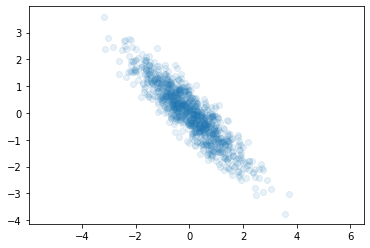

In [269]:
points = np.random.rand(2,100)

mean = [0, 0]
cov = [[1, -0.9], 
       [-0.9, 1]]
points = np.random.multivariate_normal(mean, cov, 1000).T
print(points.shape)

plt.axis('equal')
plt.scatter(points[0,:],points[1,:], alpha=0.1)

[[-0.70806111  0.70615116]
 [-0.70615116 -0.70806111]]
[-0.70806111  0.70615116]


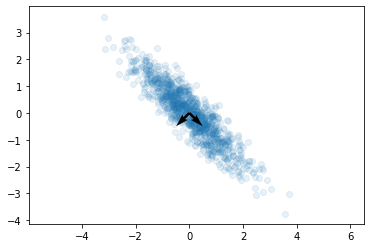

In [270]:
d_cov = (points @ points.T) / 1000
w, v = np.linalg.eig(d_cov)
# v = (v*w)
print(v)
plt.axis('equal')
plt.scatter(points[0,:],points[1,:], alpha=0.1)
plt.quiver([0,0],[0,0], v[0], v[1], scale_units='dots')
print(v[0])

In [237]:
a = np.array([[0],
              [4]])
M = [[0, -1], 
     [1, 0]]
a.T @ M @ a

array([[0]])